In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt

In [2]:
base_dir = os.path.join('..','data_files')
clean_data = os.path.join(base_dir,'clean_data')
api_data = os.path.join(base_dir,'api_calls')
prep_data = os.path.join(base_dir,'prep_data')

lakes = ['Superior','Michigan','Huron','Erie','Ontario']

lake_colors_d = {'Superior':'blue',
                 'Michigan':'red',
                 'Huron':'green',
                 'Erie':'purple',
                 'Ontario':'orange'}

In [3]:
lake_stations = {}
for lake in lakes:
    file = f'{lake}_stations.csv'
    lake_stations[lake] = pd.read_csv(os.path.join(prep_data,file))['id'].tolist()
len(lake_stations)

5

In [4]:
total_api = pd.DataFrame()
for lake in lakes:
    file = f'{lake}_22-27_GSOM.csv'
    total_api = total_api.append(pd.read_csv(os.path.join(api_data,file)))
len(total_api)

149994

In [5]:
total_api['date'] = pd.to_datetime(total_api['date'])
total_api['Year'] = total_api['date'].dt.year
total_api['Month'] = total_api['date'].dt.month.map("{:02}".format)
total_api['day'] = total_api['date'].dt.day.map("{:02}".format)
total_api['Period'] = total_api['Year'].map(str)+'-'+total_api['Month'].map(str)
total_api.sort_values('date').head()

,Unnamed: 0,date,datatype,station,attributes,value,Year,Month,day,Period
18587,58,1995-01-01,DX32,GHCND:USC00115430,",0",17,1995,01,01,1995-01
17155,55,1995-01-01,DX32,GHCND:USC00126989,",0",20,1995,01,01,1995-01
17154,54,1995-01-01,DX32,GHCND:USC00126872,"1,0",11,1995,01,01,1995-01
17153,53,1995-01-01,DX32,GHCND:USC00126830,",0",18,1995,01,01,1995-01
17152,52,1995-01-01,DX32,GHCND:USC00126705,",0",6,1995,01,01,1995-01


In [6]:
lake_data = {}
for lake in lakes:
    lake_data[lake] = total_api[total_api['station'].isin(lake_stations[lake])]
len(lake_data['Erie'])

37155

In [7]:
ice_coverage = pd.read_csv(os.path.join(clean_data,'ice_coverage.csv'),index_col='Date')
ice_coverage.head()

,Unnamed: 0,Superior,Michigan,Huron,Erie,Ontario,Weekday,Year,Month,Day,Period
Date,,,,,,,,,,,
1994-12-08,727,0.00,NaN,NaN,NaN,NaN,Thursday,1994,12,8,1994-12
1994-12-09,728,0.61,0.00,0.0,0.0,0.0,Friday,1994,12,9,1994-12
1994-12-12,729,1.01,0.00,0.8,0.0,0.0,Monday,1994,12,12,1994-12
1994-12-14,730,0.94,0.11,1.0,0.0,0.0,Wednesday,1994,12,14,1994-12
1994-12-16,731,1.12,0.14,1.4,0.0,0.3,Friday,1994,12,16,1994-12


In [8]:
def datatype_agg(datatype,grouper):
    d = {}
    for lake in lakes:
        d[lake] = lake_data[lake][lake_data[lake]['datatype']==datatype]\
            .groupby(grouper)\
            .agg({'value':'median'})\
            .rename(columns={'value':datatype})
    return d

In [9]:
def ice_agg(grouper):
    ice_d = {}
    for lake in lakes:
        ice_d[lake] = ice_coverage.groupby(grouper)\
            .agg({lake:'mean'})
#         if grouper == ['Year','Month']:
#             for yr in ice_d[lake].index.get_level_values('Year'):
#                 for i in range(1,13):
#                     if  i not in ice_mean_my['Erie'].loc[1996].index
                        
    return ice_d

In [83]:
dx32_p = datatype_agg('DX32','Period')
dt32_p = datatype_agg('DT32','Period')
ice_mean_p = ice_agg('Period')

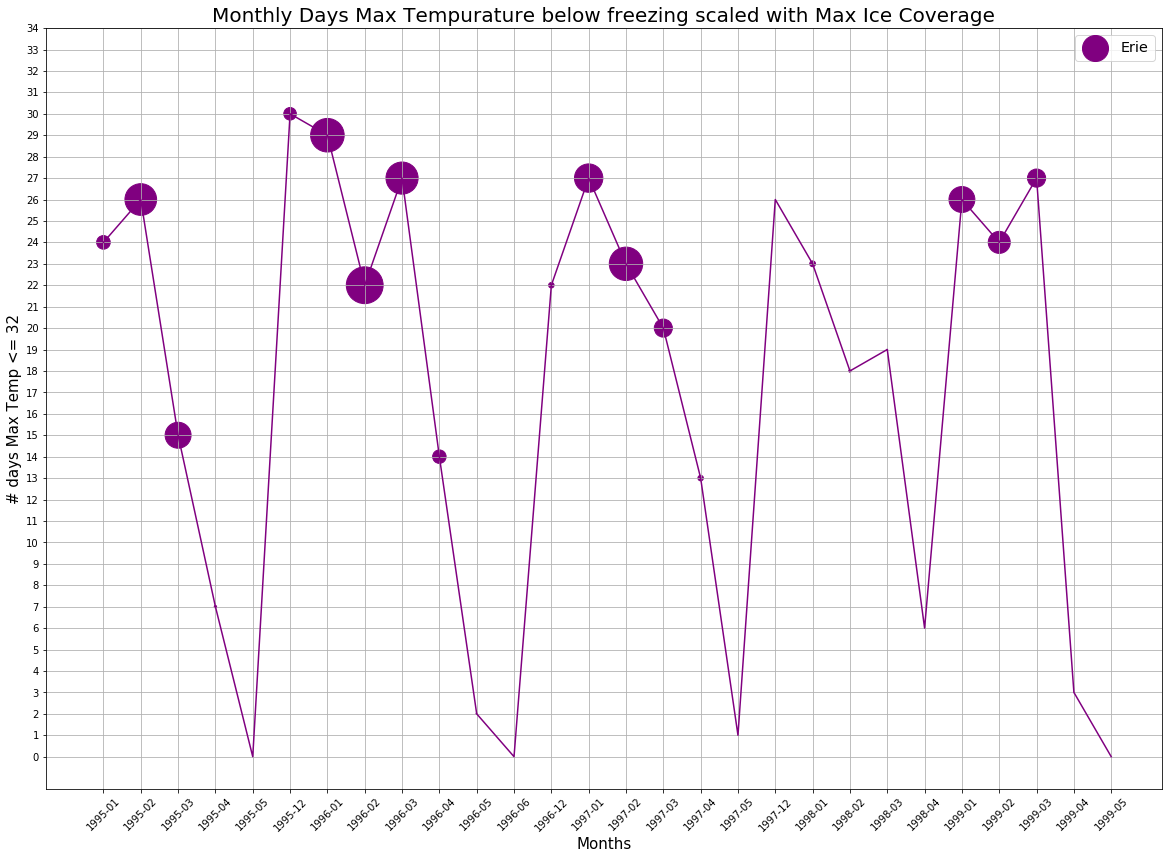

In [90]:
#This plot does not display all 12 months in each year. Only the months with ice are displayed.

plt.figure(figsize=(20,14))
plt.title('Monthly Days Max Tempurature below freezing scaled with Max Ice Coverage',fontsize=20)

lake = 'Erie'
idx = dt32_p[lake].index.intersection(ice_mean_p[lake].index)
plt.plot(idx,dt32_p[lake].loc[idx],c=lake_colors_d[lake])
plt.scatter(idx,dt32_p[lake].loc[idx],ice_mean_p[lake].loc[idx]*15,c=lake_colors_d[lake],label=f"{lake}")

plt.xlabel('Months',fontsize=15)
plt.ylabel('# days Max Temp <= 32',fontsize=15)
plt.legend(fontsize='x-large',markerscale=1)
plt.grid()
plt.xticks(rotation=45)
plt.yticks(np.arange(0,35,step=1))
plt.show()

In [78]:
dx32_my = datatype_agg('DX32',['Year','Month'])
dt32_my = datatype_agg('DT32',['Year','Month'])
ice_mean_my = ice_agg(['Year','Month'])

In [79]:
erie_ice_yrs = ice_mean_my['Erie'].index.get_level_values('Year')

In [62]:
df3 = df\
    .reset_index()\
    .assign(datetime=lambda df: pd.to_datetime(
        df["Year"].astype("str") + "-" + df["Month"].astype("str")
    )\
)\
        .set_index("datetime")["Erie"].to_frame()

In [66]:
df4 = df3.copy()

In [72]:
insert_dates = [pd.to_datetime("1995-6"), pd.to_datetime("1995-7"), pd.to_datetime("1995-8")]

In [74]:
new_data = pd.DataFrame({
    "datetime": insert_dates,
    "Erie": [0 for _ in insert_dates]
}).set_index("datetime")

In [75]:
new_data

,Erie
datetime,
1995-06-01,0
1995-07-01,0
1995-08-01,0


In [76]:
df4.append(new_data).sort_index()

,Erie
datetime,
1994-12-01,0.000000
1995-01-01,12.369231
1995-02-01,66.916667
1995-03-01,44.950000
1995-04-01,0.381818
1995-05-01,0.000000
1995-06-01,0.000000
1995-07-01,0.000000
1995-08-01,0.000000


In [14]:
df = ice_mean_my['Erie'].copy()

In [15]:
# df
# df.loc[(1995, 6), "Erie"] = 0
# df.loc[(1995, 6), "Erie"]
# df

In [24]:
pd.DataFrame([{(1995, 6): 0}])

,"(1995, 6)"
0,0


In [19]:
df2 = df.append()

In [21]:
df2

,Erie,"(1995, 6)"
"(1994, 12)",0.000000,NaN
"(1995, 1)",12.369231,NaN
"(1995, 2)",66.916667,NaN
"(1995, 3)",44.950000,NaN
"(1995, 4)",0.381818,NaN
"(1995, 5)",0.000000,NaN
"(1995, 11)",0.000000,NaN
"(1995, 12)",10.522222,NaN
"(1996, 1)",75.125000,NaN
"(1996, 2)",90.408333,NaN


In [ ]:
df.index

In [ ]:
plt.figure(figsize=(20,14))
plt.title('Year over Year mean % Ice Coverage',fontsize=20)

for yr in ice_mean_my['Erie'].index.get_level_values('Year'):
    plt.plot()

plt.xlabel('Month',fontsize=15)
plt.ylabel('Mean % Ice Coverage',fontsize=15)
plt.legend(fontsize='x-large',markerscale=1)
plt.grid()
#plt.xticks(rotation=45)
plt.yticks(np.arange(0,30,step=1))
plt.show()